In [1]:
import sys, os

import tifffile
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

bioimageio_utils.py (2): pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
2025-11-20 19:58:02.564238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Stardist Segmentation

**StarDist Segmentation** – deep learning-based method for cell and nuclei segmentation. It represents objects as star-convex polygons, enabling precise instance segmentation even in crowded images. See [GitHub repository](https://github.com/stardist/stardist)

How to install: 
```bash
conda create -n tf-gpu python=3.10 -y
conda activate tf-gpu
conda install -c conda-forge tensorflow=2.11 cudatoolkit=11.2 -y install https://github.com/stardist/stardist



In [2]:
model_versatile = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.


2025-11-20 20:05:52.454232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-20 20:05:54.633535: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 33554 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [7]:
out_dirs ={'ref_merged': '../sample-dataset-output-mariia/tissue-2D/images/fused/ref_merged.tif',
 'Gfap': '../sample-dataset-output-mariia/tissue-2D/images/fused/Gfap.tif',
 'PI': '../sample-dataset-output-mariia/tissue-2D/images/fused/PI.tif',
 'plaque': '../home/chenmn/sample-dataset-output-mariia/tissue-2D/images/fused/plaque.tif',
 'tau': '../sample-dataset-output-mariia/tissue-2D/images/fused/tau.tif'}

In [8]:
out_dir ="../sample-dataset-output-mariia/tissue-2D/images/fused2/"

In [9]:
cell_type = 'ref_merged'

In [10]:
out_dirs[cell_type]

'../sample-dataset-output-mariia/tissue-2D/images/fused/ref_merged.tif'

In [11]:
image = tifffile.imread(out_dirs[cell_type])

In [13]:
out_path = os.path.join(out_dir, f"{cell_type}_labels.tif")

In [14]:
normalized_image = normalize(image)

In [15]:
model_versatile

StarDist2D(2D_versatile_fluo): YXC → YXC
├─ Directory: None
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2], train_class_weights=(1, 1), train_epochs=800, train_steps_per_epoch=400, train_learning_rate=0.0003, train_batch_size=8, train_n_val_patches=None, train_tensorboard=True, tr

In [ ]:
labels, _ = model_versatile.predict_instances_big(normalized_image,axes ='YX', block_size=4096, min_overlap=128,prob_thresh=0.3, nms_thresh =0.6)

2025-11-20 20:10:16.282101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907


effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(96, 96)


  8%|███▍                                     | 3/36 [15:12<2:53:31, 315.51s/it]

In [ ]:
out_path

In [ ]:
# сохраняем метки
tifffile.imwrite(out_path, labels.astype('uint16'))  # или uint8, если мало объектов

print("Saved:", out_path)

In [131]:
def show_image(img, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(2,4, figsize=(16,8))
    mid = [s//2 + 600 for s in img.shape[:2]]
    for a,t,u in zip(ax.ravel(),[1,2,4,8,16,32,64,128],[16,8,4,2,1,1,1,1]):
        sl = tuple(slice(c - s//t//2, c + s//t//2, u) for s,c in zip(img.shape[:2],mid))
        a.imshow(img[sl], **kwargs)
        a.axis('off')
    plt.tight_layout()
    plt.show()

In [132]:
from stardist import export_imagej_rois, random_label_cmap
cmap = random_label_cmap()

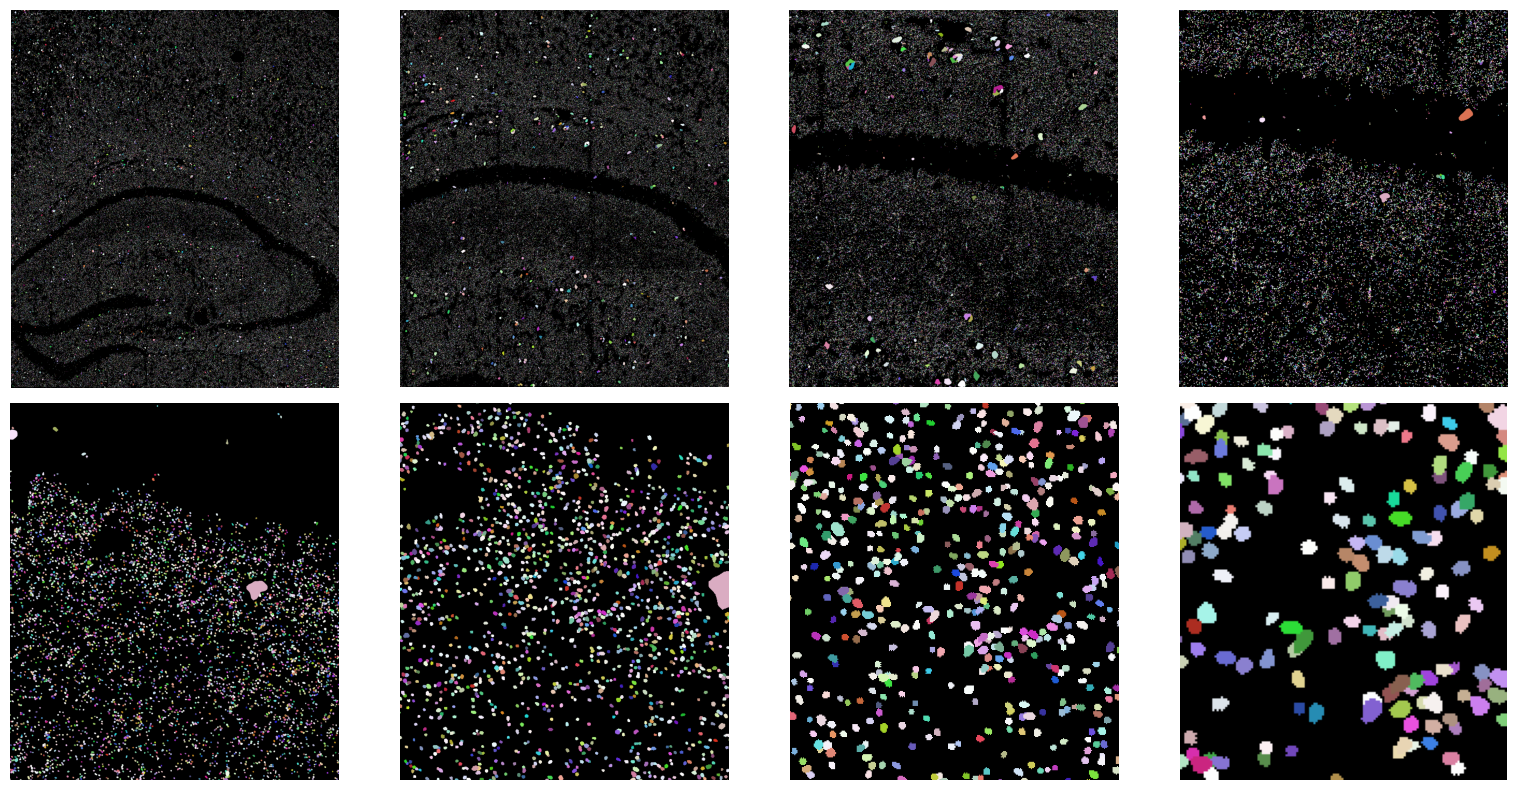

In [133]:
show_image(labels, cmap=cmap)

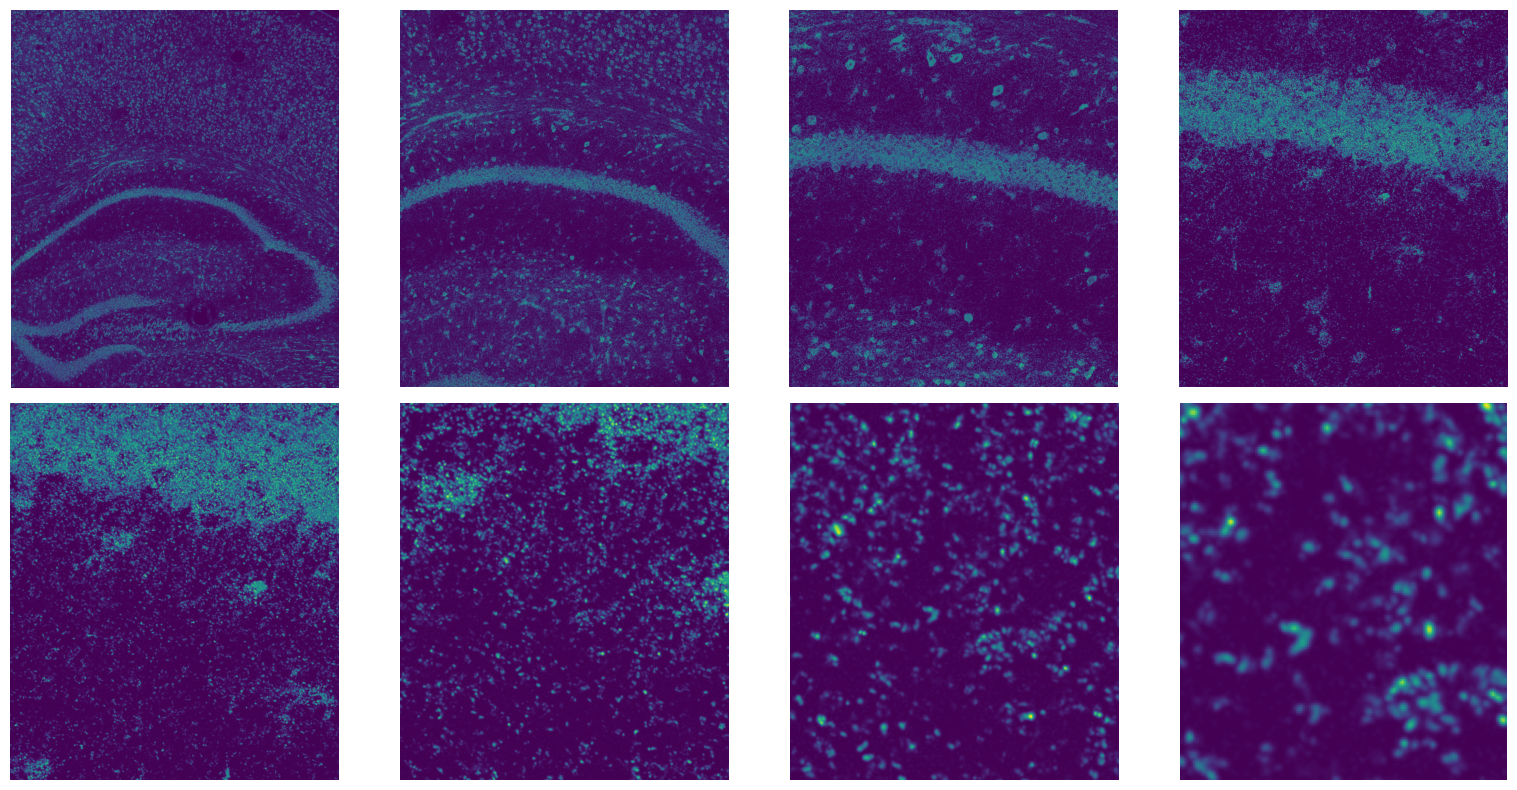

In [134]:
show_image(image)